In [13]:
# Copyright (c) Facebook, Inc. and its affiliates. All rights reserved.

# Fit a mesh via rendering

This tutorial shows how to:
- Load a mesh and textures from an `.obj` file. 
- Create a synthetic dataset by rendering a textured mesh from multiple viewpoints
- Fit a mesh to the observed synthetic images using differential silhouette rendering
- Fit a mesh and its textures using differential textured rendering

## 0. Install and Import modules

Ensure `torch` and `torchvision` are installed. If `pytorch3d` is not installed, install it using the following cell:

In [14]:
# import os
# import sys
# import torch
# need_pytorch3d=False
# try:
    # import pytorch3d
# except ModuleNotFoundError:
    # need_pytorch3d=True
# if need_pytorch3d:
#     if torch.__version__.startswith("1.9") and sys.platform.startswith("linux"):
#         # We try to install PyTorch3D via a released wheel.
#         version_str="".join([
#             f"py3{sys.version_info.minor}_cu",
#             torch.version.cuda.replace(".",""),
#             f"_pyt{torch.__version__[0:5:2]}"
#         ])
#         !pip install pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
#     else:
#         # We try to install PyTorch3D from source.
#         !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
#         !tar xzf 1.10.0.tar.gz
#         os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
#         !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [15]:
import os
import torch
from torch import nn

import matplotlib.pyplot as plt

from pytorch3d.utils import ico_sphere
import numpy as np
from tqdm.notebook import tqdm

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, save_obj

from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
from torchvision.transforms import RandomAffine, Resize

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    NormalMeshRenderer,
    MeshRasterizer,  
    NormalSoftPhongShader,
    SoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    TexturesVertex,
    TexturesUV,
    tbn_matrices,
)

from pytorch3d.renderer.mesh import tbn_matrices
# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

In [16]:
# # Soft phong shader code
# from typing import Tuple
# from torch import nn
# import torch.nn.functional as F
# from pytorch3d.renderer.utils import TensorProperties, convert_to_tensors_and_broadcast
# from pytorch3d.ops import interpolate_face_attributes
# from torch.nn.functional import normalize
# from typing import Optional
# from pytorch3d.common.types import Device
# from pytorch3d.structures.meshes import Meshes
# from pytorch3d.renderer.blending import (
#     BlendParams,
#     hard_rgb_blend,
#     sigmoid_alpha_blend,
#     softmax_rgb_blend,
# )
# from pytorch3d.renderer.lighting import PointLights
# from pytorch3d.renderer.materials import Materials
# from pytorch3d.renderer.utils import TensorProperties
# from pytorch3d.renderer.mesh.rasterizer import Fragments
# from pytorch3d.renderer.mesh.shading import flat_shading, gouraud_shading, phong_shading
# from typing import Tuple
# from torch import nn
# import torch.nn.functional as F
# from pytorch3d.renderer.utils import TensorProperties, convert_to_tensors_and_broadcast
# from pytorch3d.ops import interpolate_face_attributes

# from typing import Optional
# from pytorch3d.common.types import Device
# from pytorch3d.structures.meshes import Meshes
# from pytorch3d.renderer.blending import (
#     BlendParams,
#     hard_rgb_blend,
#     sigmoid_alpha_blend,
#     softmax_rgb_blend,
# )
# from pytorch3d.renderer.lighting import PointLights
# from pytorch3d.renderer.materials import Materials
# from pytorch3d.renderer.utils import TensorProperties
# from pytorch3d.renderer.mesh.rasterizer import Fragments
# from pytorch3d.renderer.mesh.shading import flat_shading, gouraud_shading, phong_shading
# from pytorch3d.utils import tbn_matrices

# def _apply_lighting(
#     points, normals, lights, cameras, materials
# ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
#     """
#     Args:
#         points: torch tensor of shape (N, ..., 3) or (P, 3).
#         normals: torch tensor of shape (N, ..., 3) or (P, 3)
#         lights: instance of the Lights class.
#         cameras: instance of the Cameras class.
#         materials: instance of the Materials class.

#     Returns:
#         ambient_color: same shape as materials.ambient_color
#         diffuse_color: same shape as the input points
#         specular_color: same shape as the input points
#     """
#     light_diffuse = lights.diffuse(normals=normals, points=points)
#     light_specular = lights.specular(
#         normals=normals,
#         points=points,
#         camera_position=cameras.get_camera_center(),
#         shininess=materials.shininess,
#     )
#     ambient_color = materials.ambient_color * lights.ambient_color
#     diffuse_color = materials.diffuse_color * light_diffuse
#     specular_color = materials.specular_color * light_specular

#     if normals.dim() == 2 and points.dim() == 2:
#         # If given packed inputs remove batch dim in output.
#         return (
#             ambient_color.squeeze(),
#             diffuse_color.squeeze(),
#             specular_color.squeeze(),
#         )

#     if ambient_color.ndim != diffuse_color.ndim:
#         # Reshape from (N, 3) to have dimensions compatible with
#         # diffuse_color which is of shape (N, H, W, K, 3)
#         ambient_color = ambient_color[:, None, None, None, :]
#     return ambient_color, diffuse_color, specular_color


# class NormalSoftPhongShaderv2(nn.Module):
#     """
#     Per pixel lighting - the lighting model is applied using the interpolated
#     coordinates and normals for each pixel. The blending function returns the
#     soft aggregated color using all the faces per pixel.

#     To use the default values, simply initialize the shader with the desired
#     device e.g.

#     .. code-block::

#         shader = SoftPhongShader(device=torch.device("cuda:0"))
#     """

#     def __init__(
#         self,
#         device: Device = "cpu",
#         cameras: Optional[TensorProperties] = None,
#         lights: Optional[TensorProperties] = None,
#         materials: Optional[Materials] = None,
#         blend_params: Optional[BlendParams] = None,
#         tangent_matrices: Optional[TensorProperties] = None
#     ) -> None:
#         super().__init__()
#         self.lights = lights if lights is not None else PointLights(device=device)
#         self.materials = (
#             materials if materials is not None else Materials(device=device)
#         )
#         self.cameras = cameras
#         self.blend_params = blend_params if blend_params is not None else BlendParams()
#         self.tangent_matrices = tangent_matrices

#     def to(self, device: Device):
#         # Manually move to device modules which are not subclasses of nn.Module
#         cameras = self.cameras
#         if cameras is not None:
#             self.cameras = cameras.to(device)
#         self.materials = self.materials.to(device)
#         self.lights = self.lights.to(device)
#         self.tangent_matrices = self.tangent_matrices.to(device)
#         return self

#     def forward(self, fragments: Fragments, meshes: Meshes, **kwargs) -> torch.Tensor:
#         cameras = kwargs.get("cameras", self.cameras)
#         if cameras is None:
#             msg = "Cameras must be specified either at initialization \
#                 or in the forward pass of SoftPhongShader"
#             raise ValueError(msg)

#         texels = meshes.sample_textures(fragments)
#         # Sample normals and convert back into vectors from RGB values
#         mapped_normals = meshes.sample_normalmaps(fragments)
#         lights = kwargs.get("lights", self.lights)
#         materials = kwargs.get("materials", self.materials)
#         blend_params = kwargs.get("blend_params", self.blend_params)
#         tangent_matrices = kwargs.get("tangent_matrices", self.tangent_matrices)
#         colors = phong_shading_w_normalmapv2(
#             meshes=meshes,
#             fragments=fragments,
#             texels=texels,
#             lights=lights,
#             cameras=cameras,
#             materials=materials,
#             pixel_normals=mapped_normals,
#             tangent_matrices=tangent_matrices,
#         )
#         znear = kwargs.get("znear", getattr(cameras, "znear", 1.0))
#         zfar = kwargs.get("zfar", getattr(cameras, "zfar", 100.0))
#         images = softmax_rgb_blend(
#             colors, fragments, blend_params, znear=znear, zfar=zfar
#         )
#         return images

# def phong_shading_w_normalmapv2(
#     meshes, fragments, lights, cameras, materials, texels, pixel_normals, tangent_matrices
# ) -> torch.Tensor:
#     """
#     Apply per pixel shading using pre-baked normal maps.
#     Compute the illumination for each pixel.
#     The pixel color is obtained by multiplying the pixel textures by the ambient
#     and diffuse illumination and adding the specular component.

#     Args:
#         meshes: Batch of meshes
#         fragments: Fragments named tuple with the outputs of rasterization
#         lights: Lights class containing a batch of lights
#         cameras: Cameras class containing a batch of cameras
#         materials: Materials class containing a batch of material properties
#         texels: texture per pixel of shape (N, H, W, K, 3)
#         pixel_normals: sampled normals from a normal map

#     Returns:
#         colors: (N, H, W, K, 3)
#     """
#     verts = meshes.verts_packed()  # (V, 3)
#     faces = meshes.faces_packed()  # (F, 3)
#     # vertex_normals = meshes.verts_normals_packed()  # (V, 3)
#     faces_verts = verts[faces]
#     # faces_normals = vertex_normals[faces]
#     pixel_coords = interpolate_face_attributes(
#         fragments.pix_to_face, fragments.bary_coords, faces_verts
#     )
#     pixel_tbns = tangent_matrices[fragments.pix_to_face]
#     # torch.Size([1, 128, 128, 1, 3, 3]) torch.Size([1, 128, 128, 1, 3])
#     # print(fragments.pix_to_face.shape, pixel_tbns.shape, pixel_normals.shape, torch.einsum("ijklm,ijklmn->ijklm",pixel_normals, pixel_tbns).shape)
#     # pixel_normals = interpolate_face_attributes(
#         # fragments.pix_to_face, fragments.bary_coords, faces_normals
#     # )
#     # Transform pixel normals into tangent space 
#     pixel_normals = pixel_normals * 2.0 - 1.0
#     normals = normalize(torch.einsum("ijklmn,ijklm->ijkln", pixel_tbns, pixel_normals),dim=4)

#     ambient, diffuse, specular = _apply_lighting(
#         pixel_coords, normals, lights, cameras, materials
#     )
#     colors = (ambient + diffuse) * texels + specular
#     return colors

If using **Google Colab**, fetch the utils file for plotting image grids:

In [17]:
# !wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
# from plot_image_grid import image_grid

OR if running **locally** uncomment and run the following cell:

In [18]:
 from utils.plot_image_grid import image_grid

### 1. Load a mesh and texture file

Load an `.obj` file and its associated `.mtl` file and create a **Textures** and **Meshes** object. 

**Meshes** is a unique datastructure provided in PyTorch3D for working with batches of meshes of different sizes. 

**TexturesVertex** is an auxiliary datastructure for storing vertex rgb texture information about meshes. 

**Meshes** has several class methods which are used throughout the rendering pipeline.

If running this notebook using **Google Colab**, run the following cell to fetch the mesh obj and texture files and save it at the path `data/cow_mesh`:
If running locally, the data is already available at the correct path. 

In [19]:
# !mkdir -p data/cow_mesh
# !wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
# !wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
# !wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow_texture.png

In [20]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# device = torch.device("cpu")

# Set paths
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "cow_mesh/cow.obj")
# obj_filename = os.path.join(DATA_DIR, "cube_mesh/six_colour_cube.obj")


# Load obj file
mesh = load_objs_as_meshes([obj_filename], device=device)

# We scale normalize and center the target mesh to fit in a sphere of radius 1 
# centered at (0,0,0). (scale, center) will be used to bring the predicted mesh 
# to its original center and scale.  Note that normalizing the target mesh, 
# speeds up the optimization but is not necessary!
verts = mesh.verts_packed()
N = verts.shape[0]
center = verts.mean(0)
scale = max((verts - center).abs().max(0)[0])
mesh.offset_verts_(-center)
mesh.scale_verts_((0.75 / float(scale)));

In [21]:
# cos_similarity = torch.nn.CosineSimilarity(dim=3)
# transform_range_horizontal = 100/1024
# transform_range_vertical = 100/1024
# transform = RandomAffine(0, translate=(transform_range_horizontal,transform_range_vertical), fill=0.5)
# cos_similarity(mesh.normalmaps.maps_padded(), transform(mesh.normalmaps.maps_padded().permute(0,3,1,2)).permute(0,2,3,1).squeeze().cpu().numpy()).mean()

In [22]:
# plt.figure(figsize=(7,7))
# texture_image=mesh.normalmaps.maps_padded()
# print(texture_image.shape)
# plt.imshow(texture_image.squeeze().cpu().numpy())
# plt.axis("off");

## 2. Dataset Creation

We sample different camera positions that encode multiple viewpoints of the cow.  We create a renderer with a shader that performs texture map interpolation.  We render a synthetic dataset of images of the textured cow mesh from multiple viewpoints.


(-0.5, 127.5, 127.5, -0.5)

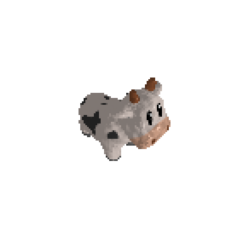

In [23]:
imsize = 128
# lights = PointLights(device=device, location=[[0.0, 0.0, -1.5]])
lights = DirectionalLights(direction=[[0.0, 0.0, -1.0]], device=device)

# We arbitrarily choose one particular view that will be used to visualize 
# results
# Changed to novel view
rand_elev = 45
rand_azim = 135
R_novel, T_novel = look_at_view_transform(dist=2.7, elev=rand_elev, azim=rand_azim)

camera = OpenGLPerspectiveCameras(device=device, R=R_novel, 
                                  T=T_novel) 


# camera = OpenGLPerspectiveCameras(device=device, R=R[None, 1, ...], 
#                                   T=T[None, 1, ...]) 

# Define the settings for rasterization and shading. Here we set the output 
# image to be of size 128X128. As we are rendering images for visualization 
# purposes only we will set faces_per_pixel=1 and blur_radius=0.0. Refer to 
# rasterize_meshes.py for explanations of these parameters.  We also leave 
# bin_size and max_faces_per_bin to their default values of None, which sets 
# their values using heuristics and ensures that the faster coarse-to-fine 
# rasterization method is used.  Refer to docs/notes/renderer.md for an 
# explanation of the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=imsize, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
    perspective_correct=False,
)

# Create a Phong renderer by composing a rasterizer and a shader. The textured 
# Phong shader will interpolate the texture uv coordinates for each vertex, 
# sample from a texture image and apply the Phong lighting model
TBN_matrices = tbn_matrices(mesh)
renderer = NormalMeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings
    ),
    shader=NormalSoftPhongShader(
        device=device, 
        cameras=camera,
        lights=lights,
        tangent_matrices=TBN_matrices,
    )
)
random_target, _ = renderer(mesh, cameras=camera, lights=lights)
random_target = random_target[...,:3]
plt.imshow(random_target.cpu().numpy()[0])
plt.axis("off")

In [24]:
# the number of different viewpoints from which we want to render the mesh.
num_views = 30
batch_views = 1
imsize = 128
# Get a batch of viewing angles. 
elev = np.random.permutation(torch.linspace(0, 360, num_views))
azim = np.random.permutation(torch.linspace(-180, 180, num_views))
# elev = np.array([45, 45, 225, 225])
# azim = np.array([-45, 135, -45, 135])

def train_test_split(list):
    return list[:len(list)//2], list[len(list)//2:]

# Place a point light in front of the object. As mentioned above, the front of 
# the cow is facing the -z direction. 

# Initialize an OpenGL perspective camera that represents a batch of different 
# viewing angles. All the cameras helper methods support mixed type inputs and 
# broadcasting. So we can view the camera from the a distance of dist=2.7, and 
# then specify elevation and azimuth angles for each viewpoint as tensors. 
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
# cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)

# We arbitrarily choose one particular view that will be used to visualize 
# results
# Changed to novel view
rand_elev = torch.rand((1,))*360
rand_azim = torch.rand((1,))*360 - 180
R_novel, T_novel = look_at_view_transform(dist=2.7, elev=rand_elev, azim=rand_azim)

camera = OpenGLPerspectiveCameras(device=device, R=R_novel, 
                                  T=T_novel) 


# camera = OpenGLPerspectiveCameras(device=device, R=R[None, 1, ...], 
#                                   T=T[None, 1, ...]) 

# Define the settings for rasterization and shading. Here we set the output 
# image to be of size 128X128. As we are rendering images for visualization 
# purposes only we will set faces_per_pixel=1 and blur_radius=0.0. Refer to 
# rasterize_meshes.py for explanations of these parameters.  We also leave 
# bin_size and max_faces_per_bin to their default values of None, which sets 
# their values using heuristics and ensures that the faster coarse-to-fine 
# rasterization method is used.  Refer to docs/notes/renderer.md for an 
# explanation of the difference between naive and coarse-to-fine rasterization. 

normals_hook = torch.Tensor()
raster_settings = RasterizationSettings(
    image_size=imsize, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
    perspective_correct=False,
)

# Create a Phong renderer by composing a rasterizer and a shader. The textured 
# Phong shader will interpolate the texture uv coordinates for each vertex, 
# sample from a texture image and apply the Phong lighting model
renderer = NormalMeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings
    ),
    shader=NormalSoftPhongShader(
        device=device, 
        cameras=camera,
        lights=lights,
        tangent_matrices=TBN_matrices,
    )
)

# for i
# Create a batch of meshes by repeating the cow mesh and associated textures. 
# Meshes has a useful `extend` method which allows us do this very easily. 
# This also extends the textures. 
meshes = mesh.extend(batch_views)
target_rgb = []
target_cameras = []
target_normals = []
print()
# Render small batches of target views on GPU and append to list to be later converted to CPU tensor
for i in range(num_views // batch_views):
    # Create cameras for rendering the batch
    cameras = OpenGLPerspectiveCameras(device=device, R=R[i*batch_views:(i+1)*batch_views], T=T[i*batch_views:(i+1)*batch_views])
    # Render the cow mesh from each viewing angle
    target_images_batch, normals = renderer(meshes, cameras=cameras, lights=lights)

    # Our multi-view cow dataset will be represented by these 2 lists of tensors,
    # each of length num_views.
    target_rgb_batch = [target_images_batch[i, ..., :3].cpu() for i in range(batch_views)]
    target_cameras_batch = [OpenGLPerspectiveCameras(device=device, R=R[None, i, ...], 
                                           T=T[None, i, ...]) for i in range(i*batch_views,(i+1)*batch_views)]
    target_rgb.extend(target_rgb_batch)
    target_cameras.extend(target_cameras_batch)
    target_normals.append(normals)


# 50/50 split of views for train/test
target_rgb, test_rgb = train_test_split(target_rgb)
target_cameras, test_cameras = train_test_split(target_cameras)
target_normals, test_normals = train_test_split(target_normals)

random_target, _ = renderer(mesh, cameras=camera, lights=lights)
random_target = random_target[...,:3]
print(len(target_rgb), len(target_cameras))


15 15


In [25]:
print(target_rgb[0].shape)


torch.Size([128, 128, 3])


Visualize the dataset:

/tmp/ipykernel_7432/2424713483.py:4: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  image_grid(np.asarray(target_rgb[:10]), rows=4, cols=5, rgb=True)
/tmp/ipykernel_7432/2424713483.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  image_grid(np.asarray(target_rgb[:10]), rows=4, cols=5, rgb=True)


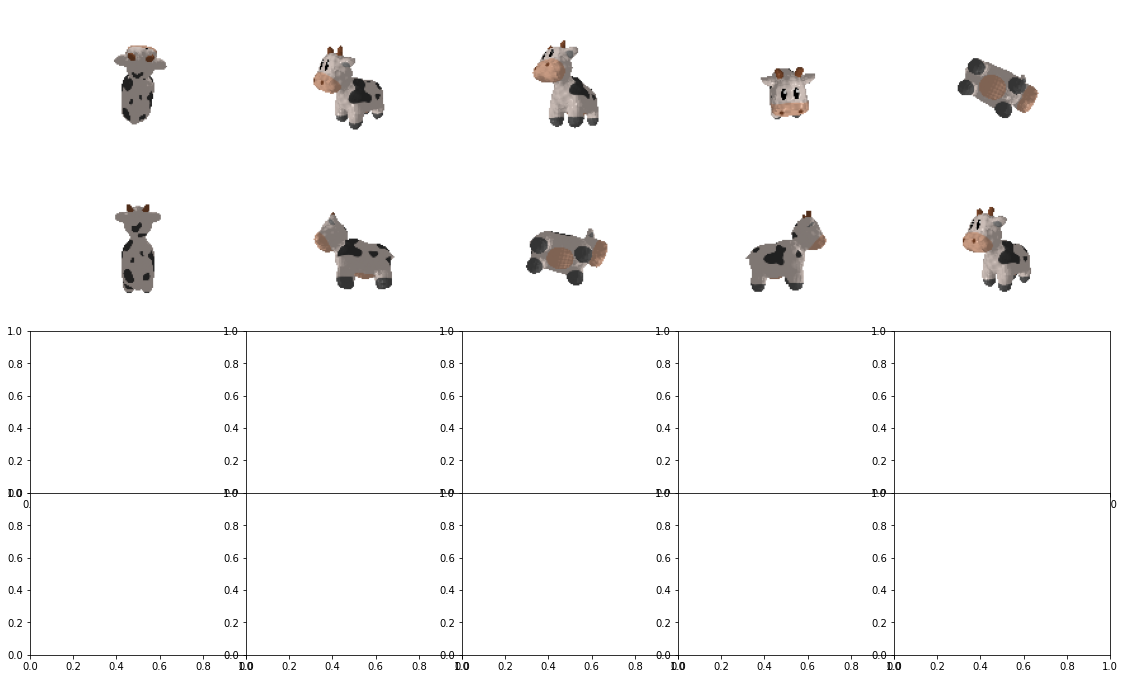

In [26]:
# RGB images
print()

image_grid(np.asarray(target_rgb[:10]), rows=4, cols=5, rgb=True)
plt.show()

Later in this tutorial, we will fit a mesh to the rendered RGB images, as well as to just images of just the cow silhouette.  For the latter case, we will render a dataset of silhouette images.  Most shaders in PyTorch3D will output an alpha channel along with the RGB image as a 4th channel in an RGBA image.  The alpha channel encodes the probability that each pixel belongs to the foreground of the object.  We construct a soft silhouette shader to render this alpha channel.

In [27]:
# # Rasterization settings for silhouette rendering  
# sigma = 1e-4
# raster_settings_silhouette = RasterizationSettings(
#     image_size=imsize, 
#     blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
#     faces_per_pixel=50, 
#     perspective_correct=False,
# )

# # Silhouette renderer 
# renderer_silhouette = MeshRenderer(
#     rasterizer=MeshRasterizer(
#         cameras=camera, 
#         raster_settings=raster_settings_silhouette
#     ),
#     shader=SoftSilhouetteShader()
# )

# # # Render silhouette images.  The 3rd channel of the rendering output is 
# # # the alpha/silhouette channel
# # silhouette_images = renderer_silhouette(meshes, cameras=cameras, lights=lights)
# # print(silhouette_images.shape)
# # target_silhouette = [silhouette_images[i, ..., 3] for i in range(num_views)]

# # # Visualize silhouette images
# # image_grid(silhouette_images.cpu().numpy(), rows=4, cols=5, rgb=False)
# # plt.show()

## 3. Mesh prediction via silhouette rendering
In the previous section, we created a dataset of images of multiple viewpoints of a cow.  In this section, we predict a mesh by observing those target images without any knowledge of the ground truth cow mesh.  We assume we know the position of the cameras and lighting.

We first define some helper functions to visualize the results of our mesh prediction:

Starting from a sphere mesh, we will learn offsets of each vertex such that the predicted mesh silhouette is more similar to the target silhouette image at each optimization step.  We begin by loading our initial sphere mesh:

We create a new differentiable renderer for rendering the silhouette of our predicted mesh:

In [28]:
# Rasterization settings for differentiable rendering, where the blur_radius
# initialization is based on Liu et al, 'Soft Rasterizer: A Differentiable 
# Renderer for Image-based 3D Reasoning', ICCV 2019
sigma = 1e-4
raster_settings_soft = RasterizationSettings(
    image_size=imsize, 
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=50, 
    perspective_correct=False,
)

# Silhouette renderer 
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_soft
    ),
    shader=SoftSilhouetteShader()
)

We initialize settings, losses, and the optimizer that will be used to iteratively fit our mesh to the target silhouettes:

We write an optimization loop to iteratively refine our predicted mesh from the sphere mesh into a mesh that matches the silhouettes of the target images:

In [29]:
# sum_loss=None
silhouette_result = mesh.clone().detach()
# visualize_prediction(silhouette_result, silhouette=True, 
#                      target_image=target_silhouette[1], camera=target_cameras[1])
# plot_losses(losses)

## 3. Mesh and texture prediction via textured rendering
We can predict both the mesh and its texture if we add an additional loss based on the comparing a predicted rendered RGB image to the target image. As before, we start with a sphere mesh.  We learn both translational offsets and RGB texture colors for each vertex in the sphere mesh.  Since our loss is based on rendered RGB pixel values instead of just the silhouette, we use a **SoftPhongShader** instead of a **SoftSilhouetteShader**.

In [30]:
# Rasterization settings for differentiable rendering, where the blur_radius
# initialization is based on Liu et al, 'Soft Rasterizer: A Differentiable 
# Renderer for Image-based 3D Reasoning', ICCV 2019

new_TBN_matrices = tbn_matrices(silhouette_result)

sigma = 1e-4
raster_settings_soft = RasterizationSettings(
    image_size=imsize, 
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=50, 
    perspective_correct=False,
)

# Differentiable soft renderer using per vertex RGB colors for texture
renderer_textured = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_soft
    ),
    shader=NormalSoftPhongShader(device=device, 
        cameras=camera,
        lights=lights,
        tangent_matrices=new_TBN_matrices)
)


We initialize settings, losses, and the optimizer that will be used to iteratively fit our mesh to the target RGB images:

We write an optimization loop to iteratively refine our predicted mesh and its vertex colors from the sphere mesh into a mesh that matches the target images:

In [31]:

# Texture generator Code
class Generator(nn.Module):
    def __init__(self, ngpu, ngf = 32, nc=3, nz=100, type = "normal", conv_layers = 4):
        super(Generator, self).__init__()
        self.type = type
        self.ngpu = ngpu
        self.deconv = nn.Sequential(
            # Testing convoluting target image first 
            # input is (nc) x 128 x 128
            nn.Conv2d(nc, ngf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout2d(p=0.25),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ngf, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout2d(p=0.25),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ngf * 2, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16
            nn.Flatten(),
            nn.Linear(ngf * 4 * 16*16, nz),
            UnsqueezeLatent(),
        )
        self.tanh = nn.Tanh()           
        scale_factor = max(8, 8*(2**(4-conv_layers)))
        self.upsampler = nn.Upsample(scale_factor=scale_factor, mode='bilinear')

        if conv_layers < 5:
            self.normal_generator = nn.Sequential(
                nn.ConvTranspose2d(int(ngf * (2**(-2))), nc, 4, 2, 1, bias=False),
                nn.ReLU(True),
                nn.ConvTranspose2d( nc, nc, 3, 1, 1, bias=False),
            )
            self.texture_generator = nn.Sequential(
                nn.ConvTranspose2d(int(ngf * (2**(-2))), nc, 4, 2, 1, bias=False),
                nn.ReLU(True),
                nn.ConvTranspose2d( nc, nc, 3, 1, 1, bias=False),
            )
        else:
            self.normal_generator = nn.Sequential(
                nn.ConvTranspose2d(int(ngf * (2**(-2))), nc, 3, 1, 1, bias=False),
                # nn.ConvTranspose2d(int(ngf * (2**(-2))), nc, 4, 2, 1, bias=False),
                nn.ReLU(True),
                nn.ConvTranspose2d( nc, nc, 3, 1, 1, bias=False),
            )
            self.texture_generator = nn.Sequential(
                # nn.ConvTranspose2d(int(ngf * (2**(-2))), nc, 4, 2, 1, bias=False),
                nn.ConvTranspose2d(int(ngf * (2**(-2))), nc, 3, 1, 1, bias=False),
                nn.ReLU(True),
                nn.ConvTranspose2d( nc, nc, 3, 1, 1, bias=False),
            )
        if type == "normal":
            self.generator = nn.Sequential(
                # input is Z, going into a convolution
                nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
                # nn.BatchNorm2d(ngf * 8),
                nn.ReLU(True),
                # nn.Dropout2d(p=0.25),
                # state size. (ngf*8) x 4 x 4
                nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
                # ResConvTranspose(nn.ConvTranspose2d(ngf, ngf, 4, 2, 1, bias=False),nn.Upsample(scale_factor=2, mode='bilinear')),
                # nn.BatchNorm2d(ngf * 4),
                nn.ReLU(True),
                # nn.Dropout2d(p=0.25),
                # state size. (ngf*4) x 8 x 8
                nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
                # ResConvTranspose(nn.ConvTranspose2d( ngf, ngf, 4, 2, 1, bias=False),nn.Upsample(scale_factor=2, mode='bilinear')),
                # nn.BatchNorm2d(ngf * 2),
                nn.ReLU(True),
                # nn.Dropout2d(p=0.25),
                # state size. (ngf*2) x 16 x 16
                nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
                # ResConvTranspose(nn.ConvTranspose2d( ngf, ngf, 4, 2, 1, bias=False),nn.Upsample(scale_factor=2, mode='bilinear')),
                # nn.BatchNorm2d(ngf),
                nn.ReLU(True),
                # nn.Dropout2d(p=0.25),
                # state size. (ngf) x 32 x 32
                # nn.ConvTranspose2d( ngf, ngf//2, 4, 2, 1, bias=False),
                # nn.BatchNorm2d(ngf//2),
                # nn.ReLU(True),
                # nn.Dropout2d(),
                # state size. (ngf) x 64 x 64
                nn.ConvTranspose2d( ngf, nc, 4, 4, 0, bias=False),
                nn.Tanh(),
                # nn.Upsample(scale_factor=4, mode='bilinear')
                # state size. (nc) x 128 x 128
            )
        elif type == "residual":
            self.generator =  nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf, 4, 1, 0, bias=False),
            # nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # nn.Dropout2d(p=0.25),
            # state size. (ngf*8) x 4 x 4
            ResConvTranspose(nn.ConvTranspose2d(ngf, ngf, 4, 2, 1, bias=False),nn.Upsample(scale_factor=2, mode='bilinear')),
            # nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # nn.Dropout2d(p=0.25),
            # state size. (ngf*4) x 8 x 8
            ResConvTranspose(nn.ConvTranspose2d( ngf, ngf, 4, 2, 1, bias=False),nn.Upsample(scale_factor=2, mode='bilinear')),
            # nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # nn.Dropout2d(p=0.25),
            # state size. (ngf*2) x 16 x 16
            ResConvTranspose(nn.ConvTranspose2d( ngf, ngf, 4, 2, 1, bias=False),nn.Upsample(scale_factor=2, mode='bilinear')),
            # nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # nn.Dropout2d(p=0.25),
            # state size. (ngf) x 32 x 32
            # nn.ConvTranspose2d( ngf, ngf//2, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(ngf//2),
            # nn.ReLU(True),
            # nn.Dropout2d(),
            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d( ngf, nc, 4, 4, 0, bias=False),
            nn.Tanh(),
            # nn.Upsample(scale_factor=4, mode='bilinear')
            # state size. (nc) x 128 x 128
        )
        elif type == "simultaneous":
            modules = [nn.ConvTranspose2d(nz, int(ngf * (2**(conv_layers-2))), 4, 1, 0, bias=False),
                nn.BatchNorm2d(int(ngf * (2**(conv_layers-2)))),
                nn.ReLU(True)]

            # deconv layers that upscale by 2, maximum to 128x128
            for i in range(conv_layers - 2, max(conv_layers - 7, -2), -1):
                modules.extend([
                nn.ConvTranspose2d(int(ngf * (2**(i))), int(ngf * (2**(i-1))), 4, 2, 1, bias=False),
                nn.BatchNorm2d(int(ngf * (2**(i-1)))),
                nn.ReLU(True)
                ])
            # convolution layers without upscaling beyond 128x128 to save on memory
            if conv_layers >= 5:
                for j in range(conv_layers - 7, -2, -1):
                    modules.extend([
                        nn.ConvTranspose2d(int(ngf * (2**(j))), int(ngf * (2**(j-1))), 3, 1, 1, bias=False),
                        nn.BatchNorm2d(int(ngf * (2**(j-1)))),
                        nn.ReLU(True) 
                    ])

            self.generator = nn.Sequential(*modules)
    def forward(self, input):
        if self.type == "simultaneous":
            result = self.generator(input)
            return self.upsampler(self.tanh(self.texture_generator(result))), self.upsampler(self.tanh(self.normal_generator(result)))
        else: 
            return self.generator(input)


In [32]:
# Discriminator code
class Discriminator(nn.Module):
    def __init__(self, ngpu, nc=3, ndf=32):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 128 x 128
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout2d(p=0.25),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout2d(p=0.25),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout2d(p=0.25),
            # state size. (ndf*4) x 16 x 16
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout2d(p=0.25),
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            # state size. (ndf*8) x 8 x 8
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*16) x 4 x 4
            nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [33]:
mse_iters_no_smoothing = []
cos_sims_no_smoothing = []
mse_iters_default = []
cos_sims_default = []
mse_iters_no_flatness = []
cos_sims_no_flatness = []

In [34]:


%matplotlib inline

# Optimize using rendered RGB image loss, rendered silhouette image loss, mesh 
# edge loss, mesh normal consistency, and mesh laplacian smoothing
map_losses = {
          "rgb": {"weight": 1.0, "values": []},
          # "adversarial": {"weight": 0.01, "values": []},
          "smoothness":{"weight":0.1, "values": []},
          "normal_smoothness":{"weight":0.001, "values": []}
         }
losses_gan = {
          "generator": {"weight": 1.0, "values": []},
          "discriminator":{"weight":1.0, "values": []}

}
# We will learn to deform the source mesh by offsetting its vertices
# The shape of the deform parameters is equal to the total number of vertices in 
# src_mesh
# src_mesh = mesh.clone()
# verts_shape = src_mesh.verts_packed().shape
# deform_verts = torch.full(verts_shape, 0.0, device=device, requires_grad=True)

# verts = src_mesh.verts_packed().to(device)
# .faces_packed().unsqueeze(dim=0).to(device)
faces_uvs = silhouette_result.textures.faces_uvs_padded()
uv_map = silhouette_result.textures.verts_uvs_padded()
# print(uv_map.shape, src_mesh.textures.verts_uvs_padded().shape)
# uv_map.requires_grad = True

# We will also learn per vertex colors for our sphere mesh that define texture 
# of the mesh
# sphere_verts_rgb = torch.full(mesh.textures.maps_padded().shape, 0.1, device=device, requires_grad=True)
# sphere_verts_rgb = torch.normal(mean=torch.full(mesh.textures.maps_padded().shape, 0.5),std=0.05).to(device)
# sphere_verts_rgb.requires_grad = True
# print(sphere_verts_rgb)

# Need to create UV map for the sphere and optimize that together with the texture

# The optimizer
# optimizer = torch.optim.Adam([sphere_verts_rgb], lr=0.001)
# new_src_mesh = src_mesh.clone()
# new_src_mesh.textures = TexturesUV(sphere_verts_rgb, faces_uvs=faces, verts_uvs=uv_map)



In [35]:
# Show a visualization comparing the rendered predicted mesh to the ground truth 
# mesh
def visualize_prediction(predicted_mesh, renderer=renderer_silhouette, 
                         target_image=random_target[0], title='', 
                         silhouette=False, camera = camera):
    inds = 3 if silhouette else range(3)
    with torch.no_grad():
        predicted_images, _ = renderer(predicted_mesh, cameras=camera)
    plt.figure(figsize=(20, 10))
    plt.tight_layout()
    plt.subplot(1, 2, 1)
    plt.imshow(predicted_images[0, ..., inds].cpu().detach().numpy())
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(target_image.cpu().detach().numpy())
    plt.axis("off")


# Plot losses as a function of optimization iteration
def plot_losses(losses):
    fig = plt.figure(figsize=(13, 5))
    ax = fig.gca()
    for k, l in losses.items():
        ax.plot(l['values'], label=k + " loss")
    ax.legend(fontsize="16")
    ax.set_xlabel("Iteration", fontsize="16")
    ax.set_ylabel("Loss", fontsize="16")
    ax.set_title("Loss vs iterations", fontsize="16")

In [36]:
def evaluate_model(eval_mesh):
    with torch.no_grad():
        # Define the settings for rasterization and shading. Here we set the output 
        # image to be of size 128X128. As we are rendering images for visualization 
        # purposes only we will set faces_per_pixel=1 and blur_radius=0.0. Refer to 
        # rasterize_meshes.py for explanations of these parameters.  We also leave 
        # bin_size and max_faces_per_bin to their default values of None, which sets 
        # their values using heuristics and ensures that the faster coarse-to-fine 
        # rasterization method is used.  Refer to docs/notes/renderer.md for an 
        # explanation of the difference between naive and coarse-to-fine rasterization. 
        raster_settings = RasterizationSettings(
            image_size=imsize, 
            blur_radius=0.0, 
            faces_per_pixel=1, 
            perspective_correct=False,
        )
        # Create a Phong renderer by composing a rasterizer and a shader. The textured 
        # Phong shader will interpolate the texture uv coordinates for each vertex, 
        # sample from a texture image and apply the Phong lighting model
        renderer = NormalMeshRenderer(
            rasterizer=MeshRasterizer(
                cameras=camera, 
                raster_settings=raster_settings
            ),
            shader=NormalSoftPhongShader(
                device=device, 
                cameras=test_cameras,
                lights=lights,
                tangent_matrices=new_TBN_matrices,
            )
        )
        test_cos_sim = torch.nn.CosineSimilarity(dim=4)
        normals_similarity = 0
        image_MSE = 0
        # Calculate RGB loss for each view point in test set
        for j in range(len(test_cameras)):
            image_predicted, normals_predicted = renderer(eval_mesh, cameras=test_cameras[j], lights=lights,)

            # Squared L2 distance between the predicted RGB image and the target 
            predicted_rgb = image_predicted[..., :3]
            predicted_rgb.squeeze()
            image_MSE += ((predicted_rgb - test_rgb[j].to(device)) ** 2).mean()
            normals_similarity += test_cos_sim(test_normals[j], normals_predicted).mean()
        mean_MSE = image_MSE / len(test_cameras)
        normals_similarity = normals_similarity / len(test_cameras)
        # visualize_prediction(eval_mesh, renderer=renderer, camera=test_cameras[1], silhouette=False,target_image = test_rgb[1])

        return mean_MSE, normals_similarity
    # print(mean_MSE)

# print(evaluate_model())

  0%|          | 0/5001 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 4, 4]         385,024
       BatchNorm2d-2            [-1, 256, 4, 4]             512
              ReLU-3            [-1, 256, 4, 4]               0
   ConvTranspose2d-4            [-1, 128, 8, 8]         524,288
       BatchNorm2d-5            [-1, 128, 8, 8]             256
              ReLU-6            [-1, 128, 8, 8]               0
   ConvTranspose2d-7           [-1, 64, 16, 16]         131,072
       BatchNorm2d-8           [-1, 64, 16, 16]             128
              ReLU-9           [-1, 64, 16, 16]               0
  ConvTranspose2d-10           [-1, 32, 32, 32]          32,768
      BatchNorm2d-11           [-1, 32, 32, 32]              64
             ReLU-12           [-1, 32, 32, 32]               0
  ConvTranspose2d-13           [-1, 16, 64, 64]           8,192
      BatchNorm2d-14           [-1, 16,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


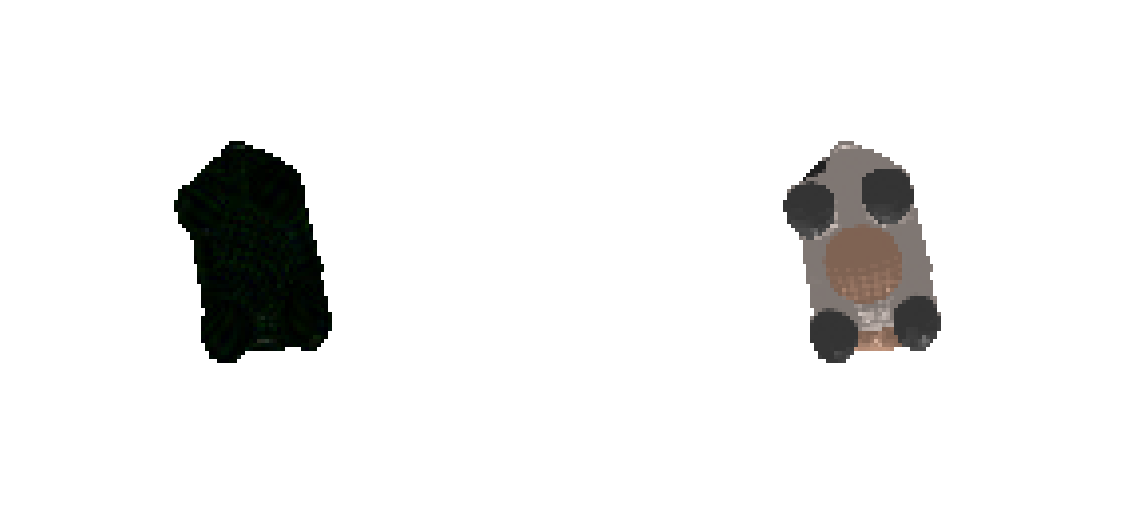

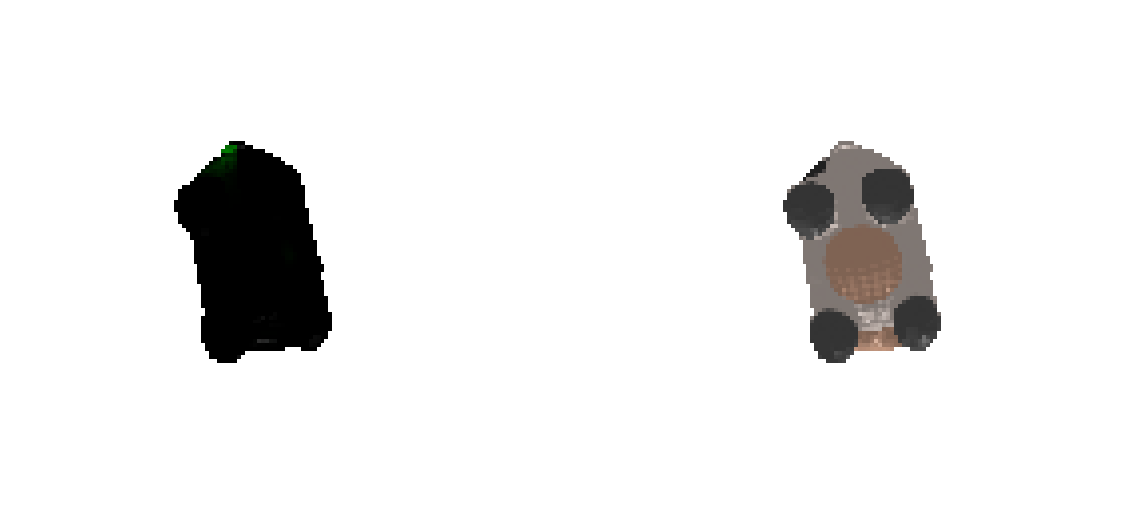

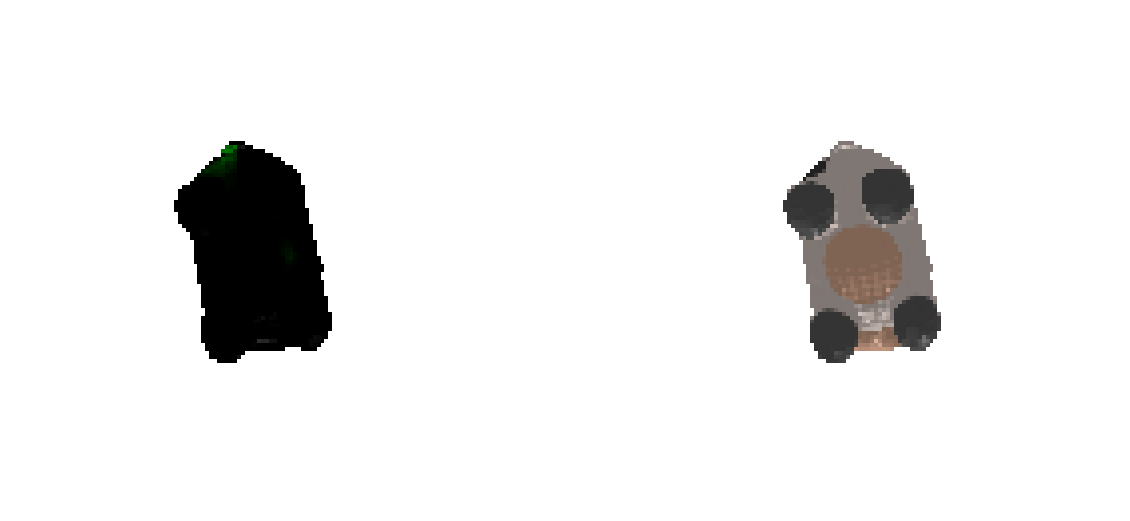

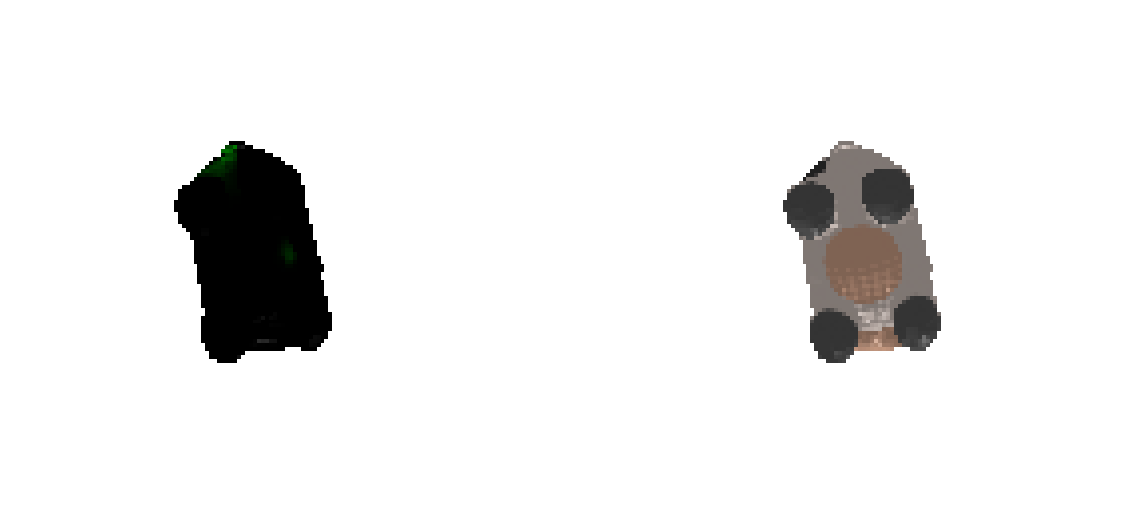

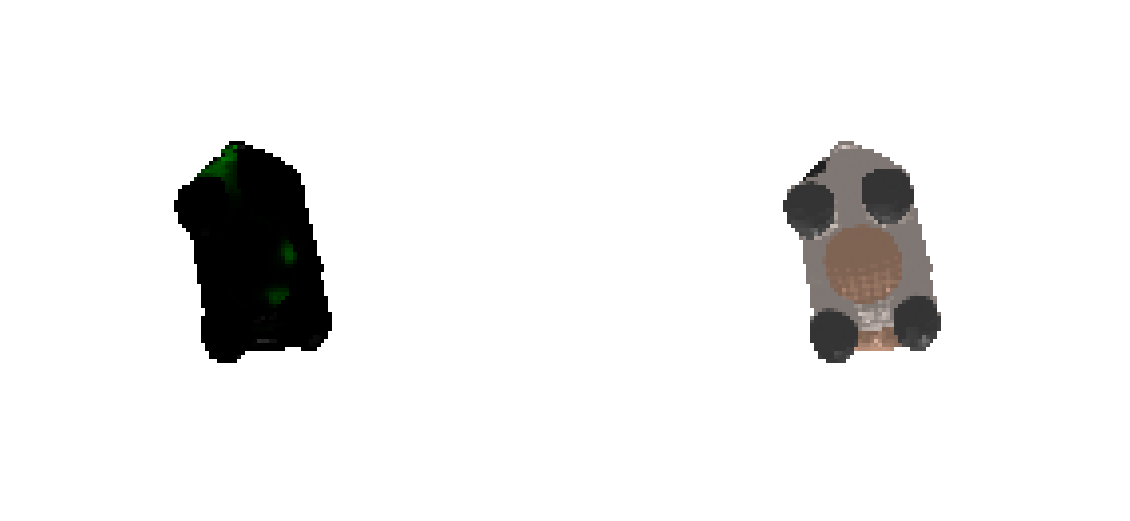

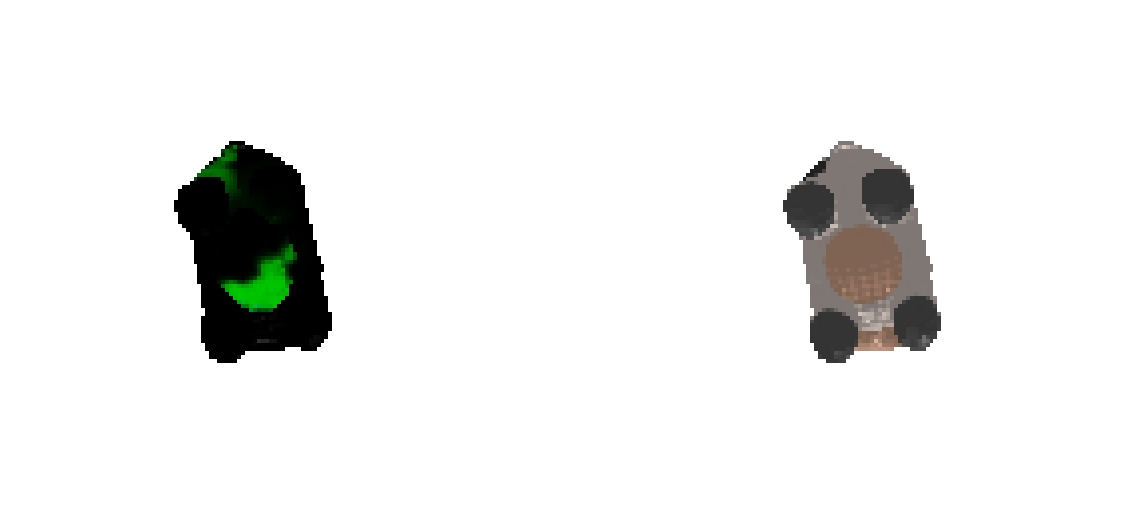

In [37]:
import torch.utils.data
from torchsummary import summary
from torch.nn.functional import normalize

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

config = {
        "ngf": 64,
        "nz": 94,
        "layers": 4,
        "lr": 0.005425492476777124,
        "beta1": 0.5076397726936703,
        "beta2": 0.9214742796191817,
        "l2": 1.698130190537183e-06,
        "amsgrad": True,
        }


# Number of views to optimize over in each SGD iteration
num_views_per_iteration = min(2, num_views)
# Number of optimization steps
Niter = 5001
# Plot period for the losses
plot_period = Niter // 5

loop = tqdm(range(Niter))
# maps = [sphere_verts_rgb.detach().cpu()]


# Adversarial loss from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
nc = 3
ngf = config["ngf"]
nz = config["nz"]
layers = config["layers"]
lr = config["lr"]
beta1 = config["beta1"]
beta2 = config["beta2"]
l2penalty = config["l2"]
amsgrad = config["amsgrad"]
class ResConvTranspose(nn.Module):
    layer = 0
    def __init__(self, deconv, upsampler):
        super().__init__()
        self.module = deconv
        self.upsampler = upsampler
        self.weight = torch.nn.Parameter(deconv.weight)

    def forward(self, inputs):
        return self.module(inputs) + self.upsampler(inputs)

class UnsqueezeLatent(nn.Module):
    layer = 0
    def __init__(self):
        super().__init__()

    def forward(self, inputs):
        return torch.unsqueeze(torch.unsqueeze(inputs, 2), 3)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.05)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.05)
        nn.init.constant_(m.bias.data, 0)


# Create discriminator for adversarial loss
ngpu = 1
workers = 2
bce_loss = nn.BCELoss()
# netD = Discriminator(ngpu).to(device)
# netD.apply(weights_init)
# real_label = 1.
# fake_label = 0.
# optimizerD = torch.optim.SGD(netD.parameters(), lr=lr)


# Create the generator
netG = Generator(ngpu, ngf, nc, nz, "simultaneous", layers).to(device)
summary(netG, ( nz, 1, 1))
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Need to create UV map for the sphere and optimize that together with the texture
# The optimizer
# maps_src_mesh.textures = TexturesUV(sphere_verts_rgb, faces_uvs=faces_uvs, verts_uvs=uv_map)

# Need to create UV map for the sphere and optimize that together with the texture
scale_factor = 1
texture_size = list(mesh.textures.maps_padded().shape)
texture_size[1] //= scale_factor
texture_size[2] //= scale_factor

print("Texture Size: {}".format(texture_size))
# sphere_verts_rgb = torch.zeros(texture_size, device=device, requires_grad=True)
# optimizer = torch.optim.Adam([sphere_verts_rgb], lr=0.001)

# sphere_verts_rgb = src_mesh.textures.maps_padded()
# sphere_verts_rgb.requires_grad = True
# The optimizer
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, beta2), weight_decay=l2penalty, amsgrad=amsgrad)

random_vector = torch.randn(1, nz, 1, 1, device=device) * 0.5
# print(random_vector.shape)
# sphere_verts_rgb = netG(target_rgb[0].to(device).unsqueeze(0).permute(0,3,1,2)).permute(0,2,3,1)
sphere_verts_rgb, normal_map_base = netG(random_vector)
print(sphere_verts_rgb.shape, normal_map_base.shape)
zero_dims = texture_size[:3]
zero_dims.append(2)
ones_dims = texture_size[:3]
ones_dims.append(1)
# begin with a flat normal map and just offset it using the generator by a small amount
normal_map_flat = torch.cat([torch.ones(zero_dims).to(device)*0.5, torch.ones(ones_dims).to(device)], dim=3)
# normal_map_base.requires_grad = True
# optimizerNorm = torch.optim.Adam([normal_map_base], lr=lr, betas=(beta1, 0.999))


maps_src_mesh = silhouette_result.clone()
maps_src_mesh.textures = TexturesUV(sphere_verts_rgb.permute(0,2,3,1), faces_uvs=faces_uvs, verts_uvs=uv_map)
maps_src_mesh.normalmaps = TexturesUV(normal_map_flat, faces_uvs=faces_uvs, verts_uvs=uv_map)
# print(maps_src_mesh.normalmaps.maps_padded().shape)

# Cosine similarity loss for normal map
cos_similarity = torch.nn.CosineSimilarity(dim=3)


# period to evaluate mesh against test views with normal rasterization
eval_period = 5

for i in loop:
    transform_range_horizontal = 5/sphere_verts_rgb.shape[2]
    transform_range_vertical = 5/sphere_verts_rgb.shape[3]
    transform = RandomAffine(0, translate=(transform_range_horizontal,transform_range_vertical))
    # Initialize optimizer
    optimizerG.zero_grad()
    
    # Deform the mesh
    # maps_src_mesh = src_mesh.offset_verts(deform_verts)
    
    # Add per vertex colors to texture the mesh
    # TODO create UV map for faces and vertices for the default sphere

    # sphere_verts_rgb = netG(target_rgb[i % len(target_rgb)].to(device).unsqueeze(0).permute(0,3,1,2)).permute(0,2,3,1) #- for generator network
    sphere_verts_rgb, normal_map_base = netG(random_vector)
    maps_src_mesh.textures = TexturesUV(sphere_verts_rgb.permute(0,2,3,1), faces_uvs=faces_uvs, verts_uvs=uv_map)
    new_normal_map = normalize(normal_map_base.permute(0,2,3,1) * 0.25 + normal_map_flat, dim=3)
    # new_normal_map = normal_map_flat
    maps_src_mesh.normalmaps = TexturesUV(new_normal_map, faces_uvs=faces_uvs, verts_uvs=uv_map)

    # Losses to smooth /regularize the mesh shape
    map_loss = {k: torch.tensor(0.0, device=device) for k in map_losses}
    # update_mesh_shape_prior_losses(maps_src_mesh, loss)
    # loss_gan = {k: torch.tensor(0.0, device=device) for k in losses_gan}

    # Randomly select two views to optimize over in this iteration.  Compared
    # to using just one view, this helps resolve ambiguities between updating
    # mesh shape vs. updating mesh texture
    rendered_rgb = []

    # Getting examples from renderer as the Generator
    random_views = np.random.permutation(len(target_cameras)).tolist()[:num_views_per_iteration]
    for j in random_views:
        images_predicted, _ = renderer_textured(maps_src_mesh, cameras=target_cameras[j], lights=lights)

        # Squared L2 distance between the predicted silhouette and the target 
        # # silhouette from our dataset
        # predicted_silhouette = images_predicted[..., 3]
        # loss_silhouette = ((predicted_silhouette - target_silhouette[j]) ** 2).mean()
        # loss["silhouette"] += loss_silhouette / num_views_per_iteration
        
        # Squared L2 distance between the predicted RGB image and the target 
        predicted_rgb = images_predicted[..., :3]
        rendered_rgb.append(predicted_rgb.squeeze())
        loss_rgb = ((predicted_rgb - target_rgb[j].to(device)) ** 2).mean()

        # Style loss WIP
        # target_rgb[j].clone().detach().permute(2,0,1).unsqueeze(0)
        # model, style_losses = get_style_model_and_losses(cnn, cnn_normalization_mean, cnn_normalization_std, target_rgb[j].clone().detach().permute(2,0,1).unsqueeze(0))
        # model_input = sphere_verts_rgb.clone().detach().to(device).permute(0,3,1,2)
        # model(model_input)
        # style_score = 0
        # for sl in style_losses:
        #     style_score += sl.loss

        # Shifted image to get the image to be smoother/gradient between pixels to be smoother
        smoothness = ((sphere_verts_rgb - transform(sphere_verts_rgb))**2).mean()
        # normal_smoothness = cos_similarity(maps_src_mesh.normalmaps.maps_padded(), transform(maps_src_mesh.normalmaps.maps_padded().permute(0,3,1,2)).permute(0,2,3,1)).mean()
        normal_smoothness = ((normal_map_flat - new_normal_map)**2).mean()
        # print(normal_smoothness)

        map_loss["rgb"] += loss_rgb / num_views_per_iteration
        map_loss["smoothness"] += smoothness / num_views_per_iteration
        map_loss["normal_smoothness"] += normal_smoothness / num_views_per_iteration
        # loss["style"] += style_score / num_views_per_iteration

    # ############################
    # # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    # ###########################
    # ## Train with all-real batch
    # netD.zero_grad()
    # # Format batch
    # real_cpu = torch.stack([target_rgb[i].to(device) for i in random_views], dim=0).permute(0,3,1,2)
    # real_cpu = real_cpu + torch.randn(real_cpu.size(), device=device)*0.1
    # b_size = num_views_per_iteration
    # label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
    # # Forward pass real batch through D
    # output = netD(real_cpu).view(-1)
    # # Calculate loss on all-real batch
    # errD_real = bce_loss(output, label)
    # # Calculate gradients for D in backward pass
    # errD_real.backward()
    # # D_x = output.mean().item()

    # ## Train with all-fake batch
    # # Generate batch of latent vectors
    # # Generate fake image batch with G
    # fake = torch.stack(rendered_rgb, dim=0).permute(0,3,1,2) + torch.randn(real_cpu.size(), device=device)*0.1
    # label.fill_(fake_label)
    # # Classify all fake batch with D
    # output = netD(fake).view(-1)
    # # Calculate D's loss on the all-fake batch
    # errD_fake = bce_loss(output, label)
    # # Calculate the gradients for this batch, accumulated (summed) with previous gradients
    # errD_fake.backward(retain_graph=True)
    # # D_G_z1 = output.mean().item()
    # # Compute error of D as sum over the fake and the real batches
    # errD = errD_real + errD_fake
    # # Update D
    # optimizerD.step()

    # ############################
    # # (2) Update G network: maximize log(D(G(z)))
    # ###########################
    # label.fill_(real_label)  # fake labels are real for generator cost
    # # Since we just updated D, perform another forward pass of all-fake batch through D
    # output = netD(fake).view(-1)
    # # Calculate G's loss based on this output
    # errG = bce_loss(output, label)
    # # Calculate gradients for G
    # # D_G_z2 = output.mean().item()
    # # Update G

    # loss["adversarial"] = errG / num_views_per_iteration
    # loss_gan["generator"] = errG / num_views_per_iteration
    # loss_gan["discriminator"] = errD / num_views_per_iteration / 2

    # Weighted sum of the losses
    map_sum_loss = torch.tensor(0.0, device=device)
    for k, l in map_loss.items():
        map_sum_loss += l * map_losses[k]["weight"]
        map_losses[k]["values"].append(float(l.detach().cpu()))
    loop.set_description("total_loss = %.6f" % map_sum_loss)


    # for k, l in loss_gan.items():
        # losses_gan[k]["values"].append(float(l.detach().cpu()))
    # Print the losses
    
    # Plot mesh
    if i % plot_period == 0:
        visualize_prediction(maps_src_mesh, renderer=renderer, title="iter: %d" % i, silhouette=False)
        # maps.append(sphere_verts_rgb.detach().cpu())

    if i % eval_period == 0:
        mse, cos_sim = evaluate_model(maps_src_mesh)
        mse_iters_no_flatness.append(mse)
        cos_sims_no_flatness.append(cos_sim)

    # Optimization step
    map_sum_loss.backward()
    optimizerG.step()

        
    # Train Discriminator
    # I want to make a generator that will create patches from the texture and warp them somehow to simulate them being on a surface. I'm thinking of some gradient mask too so that we don't learn from empty space. 
    # The true examples would be patches from the real image (probably also good to make it so that the object makes up at least some proportion of the patch for it to be accepted)

    # Train Texture/Generator
    # Here I want to use the discriminator to learn the texture better to try and fool it with the renderer serving as generator and the texture being the parameters we are tweaking/learning. 
    


In [182]:
# transform = RandomAffine(0, translate=(0.1,0.1))
# plt.imshow(transform(sphere_verts_rgb).squeeze().cpu().detach())

/tmp/ipykernel_21347/1136893239.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.plot(torch.arange(0, Niter, 5)[9:], torch.tensor(mse_iters_default_means).cpu(), label="Default config")
/tmp/ipykernel_21347/1136893239.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.plot(torch.arange(0, Niter, 5)[9:], torch.tensor(mse_iters_no_smoothing_means).cpu(), label="No smoothing")


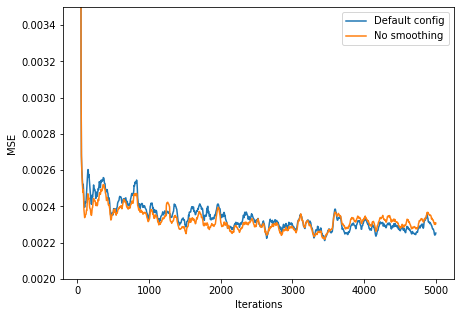

In [52]:
window_width = 10
cumsum_vec = np.cumsum(np.insert(torch.tensor(mse_iters_default).cpu(), 0, 0)) 
mse_iters_default_means = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width

cumsum_vec = np.cumsum(np.insert(torch.tensor(mse_iters_no_smoothing).cpu(), 0, 0)) 
mse_iters_no_smoothing_means = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width

plt.figure(figsize=(7,5))
plt.plot(torch.arange(0, Niter, 5)[9:], torch.tensor(mse_iters_default_means).cpu(), label="Default config")
plt.plot(torch.arange(0, Niter, 5)[9:], torch.tensor(mse_iters_no_smoothing_means).cpu(), label="No smoothing")
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.ylim(0.002, 0.0035)
plt.legend()
plt.savefig("mse_comparison.pdf", bbox_inches="tight")

/tmp/ipykernel_21347/2053146314.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.plot(torch.arange(0, Niter, 5)[9:], torch.tensor(cos_sims_default_means).cpu(), label="Default config")
/tmp/ipykernel_21347/2053146314.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.plot(torch.arange(0, Niter, 5)[9:], torch.tensor(cos_sims_no_flatness_means).cpu(), label="No flatness")


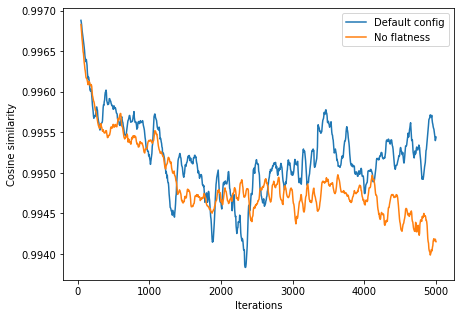

In [62]:

cumsum_vec = np.cumsum(np.insert(torch.tensor(cos_sims_default).cpu(), 0, 0)) 
cos_sims_default_means = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width

cumsum_vec = np.cumsum(np.insert(torch.tensor(cos_sims_no_flatness).cpu(), 0, 0)) 
cos_sims_no_flatness_means = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width

plt.figure(figsize=(7,5))
plt.plot(torch.arange(0, Niter, 5)[9:], torch.tensor(cos_sims_default_means).cpu(), label="Default config")
plt.plot(torch.arange(0, Niter, 5)[9:], torch.tensor(cos_sims_no_flatness_means).cpu(), label="No flatness")
plt.xlabel("Iterations")
plt.ylabel("Cosine similarity")
plt.legend()
plt.savefig("cos_sim_comparison.pdf", bbox_inches="tight")

In [172]:
# from itertools import product
# dimensions = torch.tensor(list(sphere_verts_rgb.grad.shape))
# print("Total dimension of gradient: {}\nNonzero dimension of gradient: {}".format(torch.prod(dimensions), sphere_verts_rgb.grad.count_nonzero()))
# plt.figure(figsize=(7,7))
# # from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib

# texture_image=sphere_verts_rgb.grad*10000000*10

# # texturesuv_image_matplotlib(new_src_mesh.textures, subsample=None)

# print(texture_image.shape)
# plt.imshow(texture_image.squeeze().cpu().detach())

In [173]:
# plt.hist(netG.detach().cpu().flatten().numpy(), bins=100, log=True)
# plt.show()

In [174]:
# plt.hist(normal_map_base.grad.detach().cpu().flatten().numpy(), bins=100, log=True)
# plt.show()

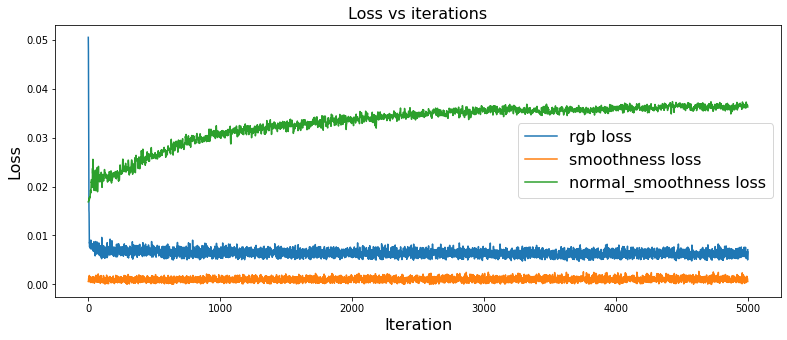

In [175]:
plot_losses(map_losses)

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)


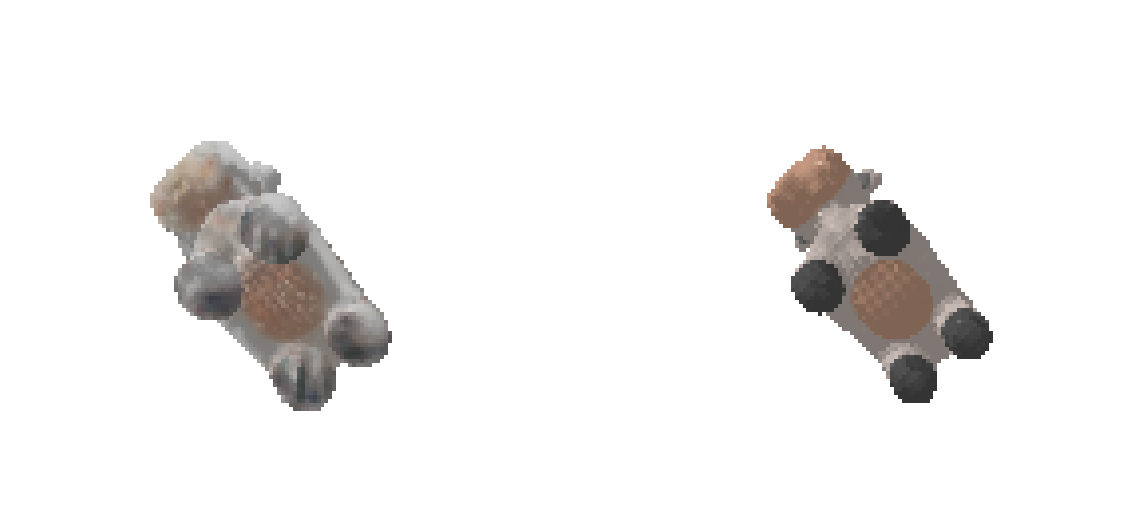

In [176]:
visualize_prediction(maps_src_mesh, renderer=renderer_textured, silhouette=False)

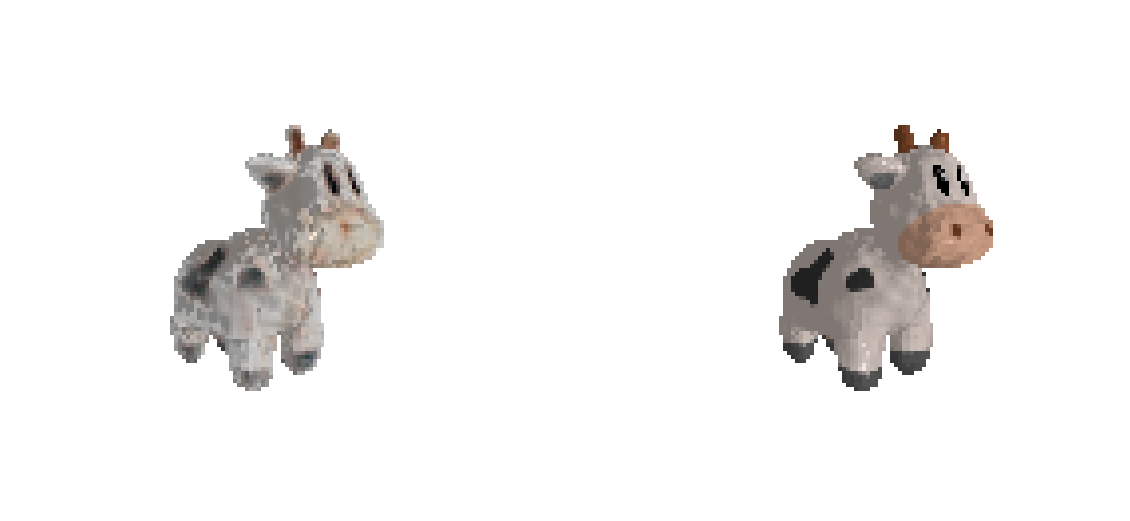

In [177]:
visualize_prediction(maps_src_mesh, renderer=renderer, silhouette=False, camera=target_cameras[3], target_image=target_rgb[3])
# plot_losses(losses)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 1024, 1024, 3])


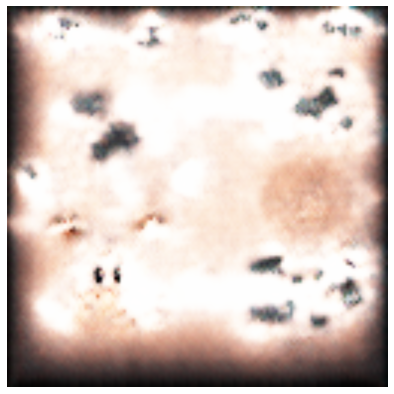

In [178]:
plt.figure(figsize=(7,7))
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib

texture_image=maps_src_mesh.textures.maps_padded()
# texturesuv_image_matplotlib(new_src_mesh.textures, subsample=None)

print(texture_image.shape)
plt.imshow(texture_image.squeeze().cpu().detach())
plt.axis("off");

torch.Size([1, 1024, 1024, 3])


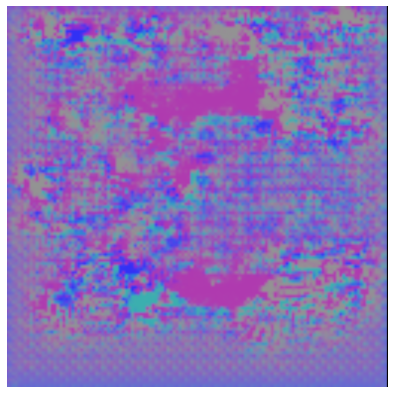

In [179]:
plt.figure(figsize=(7,7))
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib

# texture_image=new_src_mesh.normalmaps.maps_padded()

texture_image=maps_src_mesh.normalmaps.maps_padded()
# texturesuv_image_matplotlib(new_src_mesh.textures, subsample=None)

print(texture_image.shape)
plt.imshow(transform(new_normal_map).squeeze().cpu().detach())
plt.axis("off");

Save the final predicted mesh:

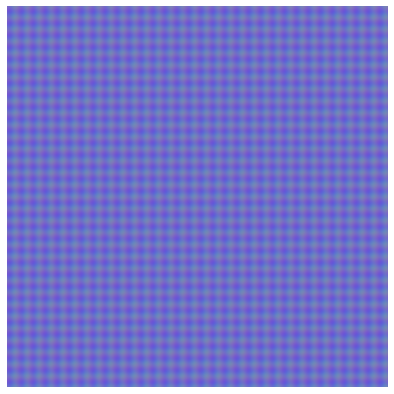

In [180]:
plt.figure(figsize=(7,7))
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib

texture_image=mesh.normalmaps.maps_padded()
# texturesuv_image_matplotlib(mesh.textures, subsample=None)
# print(src_mesh.textures.maps_padded().shape, new_src_mesh.textures.maps_padded().shape)
# print(texture_image.shape)
plt.imshow(texture_image.squeeze().cpu().detach())
plt.axis("off");

## 4. Save the final predicted mesh

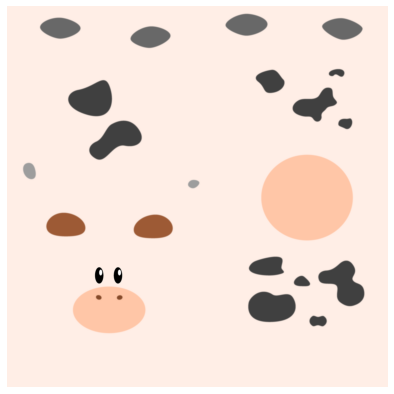

In [181]:
plt.figure(figsize=(7,7))
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib

texture_image=mesh.textures.maps_padded()
# texturesuv_image_matplotlib(mesh.textures, subsample=None)
# print(src_mesh.textures.maps_padded().shape, new_src_mesh.textures.maps_padded().shape)
# print(texture_image.shape)
plt.imshow(texture_image.squeeze().cpu().detach())
plt.axis("off");

In [38]:
# # Fetch the verts and faces of the final predicted mesh
# final_verts, final_faces = new_src_mesh.get_mesh_verts_faces(0)

# # Scale normalize back to the original target size
# final_verts = final_verts * scale + center

# # Store the predicted mesh using save_obj
# final_obj = os.path.join('./', 'final_model.obj')
# save_obj(final_obj, final_verts, final_faces)

## 5. Conclusion
In this tutorial, we learned how to load a textured mesh from an obj file, create a synthetic dataset by rendering the mesh from multiple viewpoints.  We showed how to set up an optimization loop to fit a mesh to the observed dataset images based on a rendered silhouette loss.  We then augmented this optimization loop with an additional loss based on rendered RGB images, which allowed us to predict both a mesh and its texture.